In [10]:
import argparse
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from pathlib import Path
import random
import datetime
import time
import os
import gzip, pickle
from PIL import Image

from data import get_data, get_data_real, show_imgs_real
import pandas as pd

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- cp raw_image_ver.zip into "data/animal-10n"
- unzip raw_image_ver.zip
- unzip raw_image.zip
- make_annotations_animals10n(data_dir="data/animal-10n") -> training.csv and testing.csv

In [12]:
datapath = "data"
dataset_name = "animal-10n"
seed = 123

In [13]:
train_dataset, train_dataset_original, test_dataset = get_data_real(dataset_name=dataset_name, datapath=datapath)

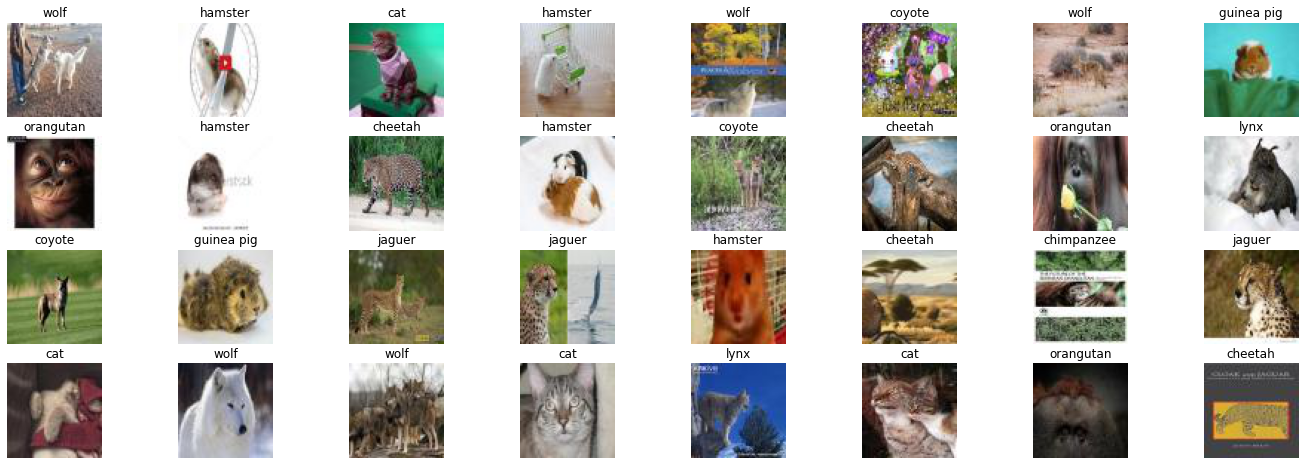

In [21]:
show_imgs_real(datapath, dataset_name, train_dataset, seed)

In [22]:
test_dataset.data.shape

(5000, 64, 64, 3)

In [23]:
# get number of classes
n_classes = len(list(train_dataset.class_to_idx.keys()))
# make targets one-hot (easier to handle in lc and sln), targets_one_hot used in lc
targets = train_dataset.targets
targets_one_hot, train_dataset.targets = np.eye(n_classes)[targets], np.eye(n_classes)[targets]
targets_test = test_dataset.targets
test_dataset.targets = np.eye(n_classes)[targets_test]
# train_dataloader is modified if lc is used
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
# train_eval_dataloader is never modified, and is used to compute the loss weights for lc
train_eval_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=2)
# test_dataloader is never modified (test dataset is not onehot yet?)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RuntimeError: No active exception to reraise

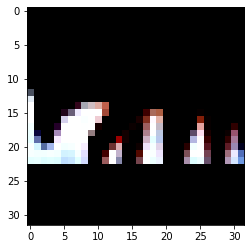

In [ ]:
def make_annotations_animals10n(data_dir):
    datasets = ["training", "testing"]

    for dataset in datasets:
        img_paths = []
        targets = []

        # List all files in a directory using os.listdir
        basepath = data_dir / Path(dataset)
        for entry in os.listdir(basepath):
            if os.path.isfile(os.path.join(basepath, entry)):
                targets.append(entry.split("_")[0])
                img_paths.append(entry)

        df = pd.DataFrame(data={"img_paths": img_paths, "targets": targets})
        path_csv = Path(f"data/animal-10n/{dataset}.csv")
        df.to_csv(path_csv ,index=False)

data_dir = Path("data/animal-10n")
make_annotations_animals10n(data_dir=data_dir)

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class Animal10N(Dataset):
    def __init__(self, root, train, transform):
        self.train = train
        self.path_annotations = root / Path("training.csv") if train else root / Path("testing.csv")
        self.annotations_df = pd.read_csv(self.path_annotations)
        self.lengthself.annotations_df.shape[0] = 
        self.img_dir = root / Path("training") if train else root / Path("testing")
        self.transform = transform
        self.data, self.targets = self.get_data_and_targets()
        self.class_to_idx = {
            "cat": 0,
            "lynx": 1,
            "wolf": 2,
            "coyote": 3,
            "cheetah": 4,
            "jaguer": 5,
            "chimpanzee": 6,
            "orangutan": 7,
            "hamster": 8,
            "guinea pig": 9
        }
    
    def get_data_and_targets(self, ):
        data = []
        targets = []
        
        for index in range(self.length):
            img_path = Path(self.img_dir) / Path(self.annotations_df.iloc[index]["img_paths"])
            img = np.asarray(Image.open(img_path))
            data.append(img)
            target = self.annotations_df.iloc[index]["targets"]
            targets.append(target)
        
        return np.array(data), targets
    
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        data = self.transform(Image.fromarray(self.data[index]))
        target = self.targets[index]
            
        return data, target, index
    
    def __repr__(self, ):
        return f"Animal-10N dataset, {'training set' if self.train else 'testing set'}, of {self.length} images"

data_dir = Path("data/animal-10n")
train_dataset = Animal10N(root=data_dir, train=False, transform=transforms.ToTensor())
# the mean of each pixel
means = train_dataset.data.mean(axis=(0,1,2)) / 255.0
# the std of each pixel
stds = train_dataset.data.std(axis=(0,1,2)) / 255.0

print(means)
print(stds)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means, stds)])

data_dir = Path("data/animal-10n")
train_dataset = Animal10N(root=data_dir, train=False, transform=transform)
test_dataset = Animal10N(root=data_dir, train=False, transform=transform)
print(train_dataset)
print(test_dataset)

In [ ]:
# get number of classes
n_classes = len(list(train_dataset.class_to_idx.keys()))
# make targets one-hot (easier to handle in lc and sln), targets_one_hot used in lc
targets = train_dataset.targets
targets_one_hot, train_dataset.targets = np.eye(n_classes)[targets], np.eye(n_classes)[targets]
targets_test = test_dataset.targets
test_dataset.targets = np.eye(n_classes)[targets_test]
# train_dataloader is modified if lc is used
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
# train_eval_dataloader is never modified, and is used to compute the loss weights for lc
train_eval_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=2)
# test_dataloader is never modified (test dataset is not onehot yet?)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
len(train_dataloader)